#### Question 1

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
np.random.seed(100)

### Change T and k values and run 1000 simulations under each group        
sig=0.5
bigT=T*2
mu_x=1
sig_x=2
k=4
b0=0.5
b1=1
nsim = 1000
kvec = [2,4,8,10]
Tvec = [25,50,75,100]
outp =np.zeros((nsim,len(Tvec),len(kvec),5))
for tdx,T in enumerate(Tvec):
    bigT = T*2
    for kdx,k in enumerate(kvec):
        for isim in range(nsim):
            e = np.random.normal(0,sig,size=(bigT,1))
            x = np.random.normal(mu_x,sig_x,size=(bigT,1))
            x_t=x
            y=b0+(b1*x_t)+e
            x_t = sm.add_constant(x)
            sample = np.random.permutation(bigT)
            train = sample[:int(bigT/2)]
            test = sample[int(bigT/2):]
            ytr = y[train]
            xtr = x_t[train]
            model=smf.OLS(y[train],x_t[train]).fit()
            z=model.predict(x_t[test])
            mspe_true = ((y[test]-model.predict(x_t[test]))**2).mean()
            sample = np.random.permutation(T)
            mspe =np.zeros(k)
            for j in range(k):    
                train_l = sample[:int((k-1-j)*T/k)]
                train_u = sample[int((k-j)*T/k):]
                train = np.concatenate((train_l,train_u),0)
                test = sample[int((k-1-j)*T/k):int((k-j)*T/k)]
                model = smf.OLS(ytr[train],xtr[train]).fit()
                mspe[j] = ((ytr[test]-model.predict(xtr[test]))**2).mean()
            mspe_cv = mspe.mean()
            outp[isim,tdx,kdx] = np.array((T,k,mspe_true,mspe_cv,mspe_cv-mspe_true))

## Convert Array to DataFrame for analysis
df=pd.DataFrame(np.vstack(outp[:,:,:].mean(0)))
df.columns=['T','k','mspe_actual','mspe_crossvalid','difference']
df

## Comments:
# MSPE Actual is around 8 for all different values of T - 10,25,50,75,100
# MSPE Cross Validation decreases for evey T and k combination as 
# number of splits increases ---> as k increases more data are feeded
# into training the model and MSPE cross validation decreases
############################
# Result:
# From the simulation results we can comment that for any value of T,
# k=2 splits seems optimum as difference between MSPE Actual 
# and MSPE Cross Validation seems minimum
############################################################################

,T,k,mspe_actual,mspe_crossvalid,difference
0,25.0,2.0,7.978254,7.565869,-0.412385
1,25.0,4.0,7.872653,6.951630,-0.921023
2,25.0,8.0,7.910748,5.649310,-2.261438
3,25.0,10.0,8.071310,4.926897,-3.144414
4,50.0,2.0,8.104254,7.979666,-0.124588
5,50.0,4.0,8.024761,7.601483,-0.423278
6,50.0,8.0,8.061416,6.973445,-1.087971
7,50.0,10.0,8.156120,6.629674,-1.526446
8,75.0,2.0,8.079486,8.002217,-0.077269
9,75.0,4.0,8.162480,7.786868,-0.375612


#### Question 2

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
np.random.seed(100) 
pd.set_option('display.max_columns',10)
pd.set_option('display.width',None)
## Betas, Bootstraps are variable
bvec=[-0.1,0,0.1,0.2]
T=100
nsim = 1000
b0 = 1
boots=[10,20,30,50]
sig=0.5
mu_x=1
outp =np.zeros((len(bvec),len(boots),6))
outp.shape
for bdx,b1 in enumerate(bvec):      
    for btx,boot in enumerate(boots):
        reject_boot = 0
        reject_both = 0
        reject_orig=0
        for isim in range(nsim):
            e = np.random.normal(0,sig,size=(T,1))
            x = np.random.normal(mu_x,sig,size=(T,1))
            y=b0+(b1*x)+e
            x = sm.add_constant(x)
            model_orig=smf.OLS(y,x).fit()
            # Create confindence interval for b1
            ci=np.zeros(int(boot))
            for b in range(boot):  ## Bootstrapping to find CI
                # Create a resample index
                resamp=np.random.randint(T, size=int(0.5*T)) #Re-sampling with replacement
                model = smf.OLS(y[resamp],x[resamp]).fit()
                ci[b] = model.params[1]
                #print(model.params[1])
            ci.sort()
            ci_lower = ci[int(boot*0.025)]
            ci_upper = ci[int(boot*0.975)]
            ## Empirical t-tests - Reject Null when CI follows a trend
            if not(0>=ci_lower and 0<=ci_upper): reject_boot+=1
            if not(0>=ci_lower and 0<=ci_upper) and model_orig.pvalues[1]<0.05: reject_both+=1
            if model_orig.pvalues[1]<0.05: reject_orig+=1
        outp[bdx,btx] = np.array((b1,boot,nsim,reject_orig,reject_boot,reject_both))
## Convert to Dataframe for analysis
df=pd.DataFrame(np.vstack(outp))
df.columns=['Betas','Bootstraps','No_of_Simulation','Reject_Actual','Reject_Bootstrap','Reject_Both']
df['Power of the Test(when Beta=0, its Size of Test)']=(df['Reject_Both']/df['No_of_Simulation'])*100
df

,Betas,Bootstraps,No_of_Simulation,Reject_Actual,Reject_Bootstrap,Reject_Both,"Power of the Test(when Beta=0, its Size of Test)"
0,-0.1,10.0,1000.0,159.0,186.0,108.0,10.8
1,-0.1,20.0,1000.0,153.0,100.0,71.0,7.1
2,-0.1,30.0,1000.0,183.0,56.0,52.0,5.2
3,-0.1,50.0,1000.0,181.0,97.0,87.0,8.7
4,0.0,10.0,1000.0,47.0,87.0,28.0,2.8
5,0.0,20.0,1000.0,42.0,27.0,17.0,1.7
6,0.0,30.0,1000.0,50.0,18.0,13.0,1.3
7,0.0,50.0,1000.0,51.0,17.0,14.0,1.4
8,0.1,10.0,1000.0,164.0,199.0,106.0,10.6
9,0.1,20.0,1000.0,159.0,90.0,69.0,6.9


#### Question 3

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

In [6]:
btc=pd.read_csv("bitcoin.csv")
snp500=pd.read_csv("SP500.csv")

gold=pd.read_csv("GOLDAMGBD228NLBM.csv")

dexus=pd.read_csv("DEXUSEU.csv")

dcoil=pd.read_csv("DCOILWTICO.csv")

In [7]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
from IPython.display import display
display(btc.head())
display(snp500.head())
display(gold.head())
display(dexus.head())
display(dcoil.head())

,DATE,Close Price
0,1/1/2014,770.44
1,1/2/2014,808.05
2,1/3/2014,830.02
3,1/4/2014,858.98
4,1/5/2014,940.10


,DATE,SP500
0,10/16/2013,1721.54
1,10/17/2013,1733.15
2,10/18/2013,1744.5
3,10/21/2013,1744.66
4,10/22/2013,1754.67


,DATE,GOLDAMGBD228NLBM
0,10/18/2013,1317
1,10/21/2013,1316
2,10/22/2013,1311.75
3,10/23/2013,1333
4,10/24/2013,1336.25


,DATE,DEXUSEU
0,2013-10-15,1.3494
1,2013-10-16,1.3490
2,2013-10-17,1.3664
3,2013-10-18,1.3693
4,2013-10-21,1.3672


,DATE,DCOILWTICO
0,2013-10-18,100.87
1,2013-10-21,99.28
2,2013-10-22,97.63
3,2013-10-23,96.90
4,2013-10-24,96.65


In [10]:
from IPython.display import display
display(btc.shape)
display(snp500.shape)
display(gold.shape)
display(dexus.shape)
display(dcoil.shape)

(1751, 2)

(1305, 2)

(1305, 2)

(1304, 2)

(1302, 2)

In [12]:
btc['DATE'] = pd.to_datetime(btc.DATE)
snp500['DATE'] = pd.to_datetime(snp500.DATE)
gold['DATE'] = pd.to_datetime(gold.DATE)
dexus['DATE'] = pd.to_datetime(dexus.DATE)
dcoil['DATE'] = pd.to_datetime(dcoil.DATE)


In [13]:
data=pd.merge(pd.merge(pd.merge(pd.merge(btc,dexus,on='DATE'),dcoil,on='DATE'),snp500,on='DATE'),gold,on='DATE')

In [14]:
data.head()

,DATE,Close Price,DEXUSEU,DCOILWTICO,SP500,GOLDAMGBD228NLBM
0,2014-01-01,770.44,.,.,.,.
1,2014-01-02,808.05,1.3670,95.14,1831.98,1219.75
2,2014-01-03,830.02,1.3606,93.66,1831.37,1232.25
3,2014-01-06,951.39,1.3636,93.12,1826.77,1238
4,2014-01-07,810.58,1.3618,93.31,1837.88,1237.5


In [15]:
import numpy as np
data=data.replace('.', np.NaN)
data = data.fillna(method='pad')
data=data[1:]


In [22]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247 entries, 1 to 1247
Data columns (total 6 columns):
DATE                1247 non-null datetime64[ns]
Close Price         1247 non-null float64
DEXUSEU             1247 non-null object
DCOILWTICO          1247 non-null object
SP500               1247 non-null object
GOLDAMGBD228NLBM    1247 non-null object
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 68.2+ KB
None


In [23]:
data['DEXUSEU'] = data.DEXUSEU.astype(float)
data['DCOILWTICO'] = data.DCOILWTICO.astype(float)
data['SP500'] = data.SP500.astype(float)
data['GOLDAMGBD228NLBM'] = data.GOLDAMGBD228NLBM.astype(float)

In [24]:
columns=['Close Price', 'DEXUSEU', 'DCOILWTICO', 'SP500', 'GOLDAMGBD228NLBM']
columns

['Close Price', 'DEXUSEU', 'DCOILWTICO', 'SP500', 'GOLDAMGBD228NLBM']

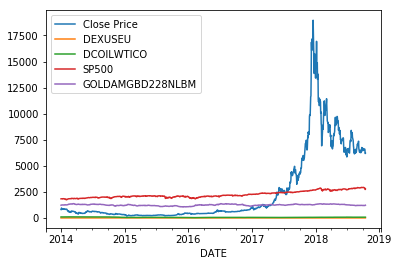

In [25]:
data[[x for x in columns] + 
   ['DATE']].groupby('DATE').sum().plot()

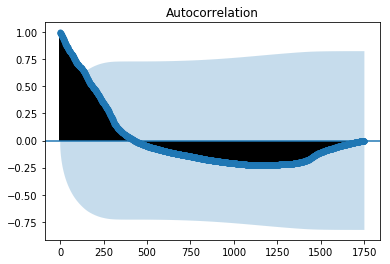

In [26]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = Series.from_csv('bitcoin.csv', header=0)
plot_acf(series)
pyplot.show()

In [27]:
import datetime

date_before = datetime.date(2016, 12, 31)
bd = data[data['DATE'] > pd.to_datetime(date_before)]

In [28]:
bd.head()

,DATE,Close Price,DEXUSEU,DCOILWTICO,SP500,GOLDAMGBD228NLBM
783,2017-01-02,1018.05,1.0552,53.75,2238.83,1159.10
784,2017-01-03,1030.82,1.0416,52.36,2257.83,1148.65
785,2017-01-04,1129.87,1.0476,53.26,2270.75,1165.90
786,2017-01-05,1005.81,1.0598,53.77,2269.00,1173.05
787,2017-01-06,895.67,1.0560,53.98,2276.98,1178.00


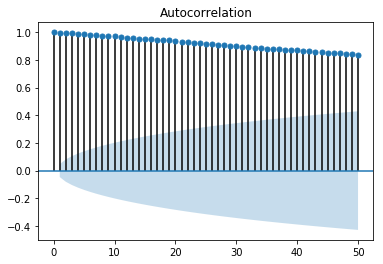

In [29]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series1 = bd.iloc[:,1]
plot_acf(series, lags=50)
pyplot.show()

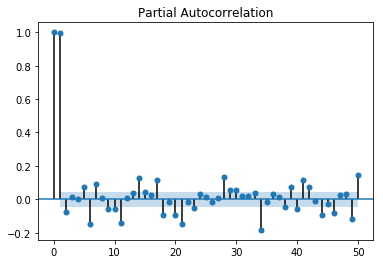

In [30]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
series1 = bd.iloc[:,1]
plot_pacf(series, lags=50)
pyplot.show()

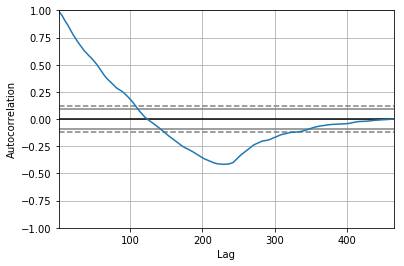

In [31]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series1)
pyplot.show()

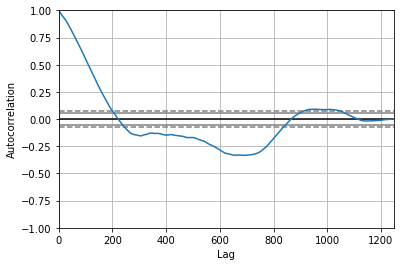

In [32]:
series2 = data.iloc[:,2]
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series2)
pyplot.show()

In [33]:
from numpy import log
series1=log(series1)

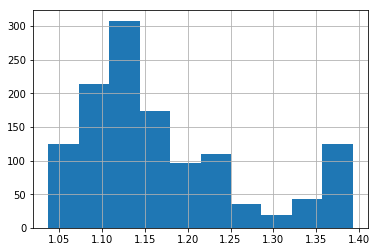

In [34]:
# Plot histogram
series2.hist()
plt.show()

In [35]:
import statsmodels.api as sm
import statsmodels.tsa.stattools

for i in range(0,30):
    print(statsmodels.tsa.stattools.kpss(series, regression='ct', lags=i, store=False))

(22.451026623723287, 0.01, 0, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(11.254386451993767, 0.01, 1, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(7.51909175687746, 0.01, 2, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(5.650826796470992, 0.01, 3, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(4.529717128984608, 0.01, 4, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(3.7821352657998606, 0.01, 5, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(3.2481934495324447, 0.01, 6, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(2.847760905982282, 0.01, 7, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(2.5363059343733116, 0.01, 8, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(2.2871535161902887, 0.01, 9, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(2.0833332929690824, 0.01, 10, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(1.9135631712577101, 0.01, 11, {'10%': 0.119, '

C:\Users\ramit\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\ramit\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\ramit\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\ramit\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\ramit\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-va

In [36]:
statsmodels.tsa.stattools.kpss(series, regression='ct', lags=None, store=False)

C:\Users\ramit\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(0.9101393068548536,
 0.01,
 25,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [37]:
import pandas
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA

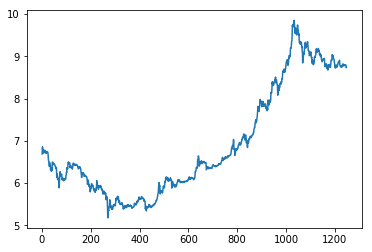

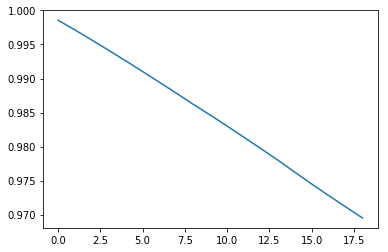

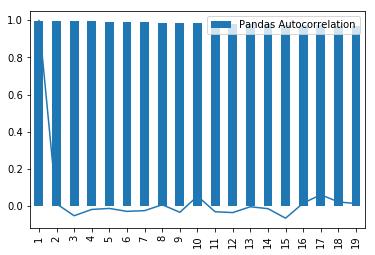

(0.17009642859469212,
 0.9705336296784631,
 0,
 1246,
 {'1%': -3.4356090875394525,
  '5%': -2.863862410805964,
  '10%': -2.568006480268158},
 -4164.137163703969)

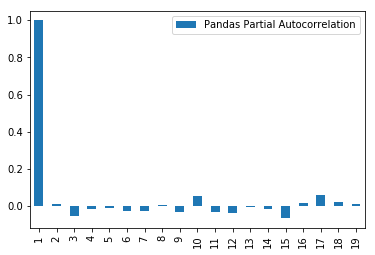

In [38]:
lnprice=np.log(data['Close Price'])
lnprice
plt.plot(lnprice)
plt.show()
acf_1 =  acf(lnprice)[1:20]
plt.plot(acf_1)
plt.show()
test_df = pandas.DataFrame([acf_1]).T
test_df.columns = ['Pandas Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
pacf_1 =  pacf(lnprice)[1:20]
plt.plot(pacf_1)
plt.show()
test_df = pandas.DataFrame([pacf_1]).T
test_df.columns = ['Pandas Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
result = ts.adfuller(lnprice, 1)
result

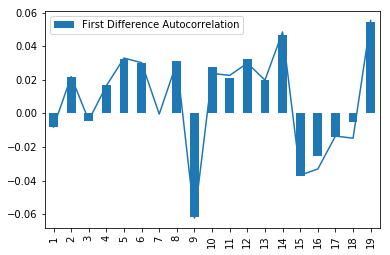

In [39]:
lnprice_diff=lnprice-lnprice.shift()
diff=lnprice_diff.dropna()
acf_1_diff =  acf(diff)[1:20]
test_df = pandas.DataFrame([acf_1_diff]).T
test_df.columns = ['First Difference Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
pacf_1_diff =  pacf(diff)[1:20]
plt.plot(pacf_1_diff)
plt.show()

In [40]:
price_matrix=lnprice.as_matrix()
model = ARIMA(price_matrix, order=(3,1,0))
model_fit = model.fit(disp=0)


In [41]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1246
Model:                 ARIMA(3, 1, 0)   Log Likelihood                2086.424
Method:                       css-mle   S.D. of innovations              0.045
Date:                Thu, 18 Oct 2018   AIC                          -4162.848
Time:                        23:24:11   BIC                          -4137.210
Sample:                             1   HQIC                         -4153.208
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.263      0.207      -0.001       0.004
ar.L1.D.y     -0.0078      0.028     -0.277      0.782      -0.063       0.048
ar.L2.D.y      0.0219      0.028      0.772      0.4

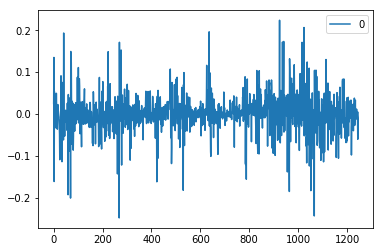

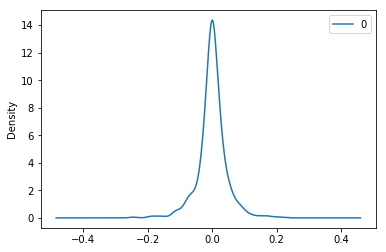

                 0
count  1246.000000
mean     -0.000003
std       0.045364
min      -0.248226
25%      -0.017640
50%       0.000674
75%       0.018597
max       0.223896


In [42]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [43]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=1190.413688, expected=1230.020000
predicted=1231.134162, expected=1260.920000
predicted=1256.447629, expected=1290.790000
predicted=1289.030732, expected=1267.680000
predicted=1265.606421, expected=1277.680000
predicted=1281.876724, expected=1280.870000
predicted=1279.380580, expected=1232.430000
predicted=1232.928827, expected=1150.480000
predicted=1156.055558, expected=1191.810000
predicted=1200.787798, expected=1117.020000
predicted=1109.745418, expected=1181.640000
predicted=1189.200188, expected=1229.500000
predicted=1219.842354, expected=1243.240000
predicted=1240.381870, expected=1246.310000
predicted=1246.704848, expected=1259.600000
predicted=1259.999115, expected=1172.910000
predicted=1173.331896, expected=1070.130000
predicted=1079.270271, expected=970.600000
predicted=973.417550, expected=1017.800000
predicted=1026.454899, expected=1041.340000
predicted=1036.057924, expected=1115.040000
predicted=1115.069369, expected=1037.440000
predicted=1029.667492, expected=10

predicted=4311.428266, expected=4422.120000
predicted=4387.568380, expected=4626.720000
predicted=4617.342822, expected=4638.100000
predicted=4660.647763, expected=4317.540000
predicted=4336.082496, expected=4291.880000
predicted=4278.042351, expected=4191.170000
predicted=4186.247556, expected=4188.840000
predicted=4184.267418, expected=4148.270000
predicted=4148.881056, expected=3874.260000
predicted=3879.263125, expected=3226.410000
predicted=3180.900719, expected=3686.900000
predicted=3633.883247, expected=3678.740000
predicted=3675.759775, expected=3672.570000
predicted=3687.431787, expected=4067.080000
predicted=4048.600319, expected=3897.000000
predicted=3920.381402, expected=3858.090000
predicted=3888.969671, expected=3612.680000
predicted=3620.090206, expected=3603.310000
predicted=3596.400924, expected=3777.290000
predicted=3757.678240, expected=3662.120000
predicted=3674.574758, expected=3927.500000
predicted=3916.543519, expected=3895.510000
predicted=3902.393067, expected=

predicted=10653.458006, expected=9906.800000
predicted=9870.437802, expected=9299.280000
predicted=9264.418051, expected=9237.050000
predicted=9246.559883, expected=8787.160000
predicted=8733.140774, expected=9532.740000
predicted=9629.047761, expected=9118.270000
predicted=9046.079554, expected=9144.150000
predicted=9182.023163, expected=8196.900000
predicted=8109.503009, expected=8256.990000
predicted=8298.590028, expected=8269.330000
predicted=8264.037487, expected=7862.110000
predicted=7830.143429, expected=8196.020000
predicted=8243.752256, expected=8594.190000
predicted=8617.169949, expected=8915.900000
predicted=8940.861700, expected=8895.400000
predicted=8892.512592, expected=8712.890000
predicted=8705.638360, expected=8918.740000
predicted=8948.370733, expected=8535.890000
predicted=8497.036161, expected=8449.830000
predicted=8462.375735, expected=8138.340000
predicted=8113.001213, expected=7790.160000
predicted=7771.604837, expected=7937.200000
predicted=7962.151725, expected

KeyboardInterrupt: 

In [44]:
X = data.values

In [45]:
series

DATE
2014-01-01     770.44
2014-01-02     808.05
2014-01-03     830.02
2014-01-04     858.98
2014-01-05     940.10
2014-01-06     951.39
2014-01-07     810.58
2014-01-08     859.95
2014-01-09     860.89
2014-01-10     884.67
2014-01-11     930.90
2014-01-12     873.26
2014-01-13     857.96
2014-01-14     851.83
2014-01-15     874.71
2014-01-16     847.37
2014-01-17     828.22
2014-01-18     843.76
2014-01-19     878.68
2014-01-20     871.05
2014-01-21     874.29
2014-01-22     863.95
2014-01-23     854.35
2014-01-24     825.12
2014-01-25     861.85
2014-01-26     880.15
2014-01-27     814.53
2014-01-28     833.94
2014-01-29     837.51
2014-01-30     845.85
               ...   
2018-09-18    6334.20
2018-09-19    6388.98
2018-09-20    6491.64
2018-09-21    6753.18
2018-09-22    6712.17
2018-09-23    6701.30
2018-09-24    6581.51
2018-09-25    6434.65
2018-09-26    6458.65
2018-09-27    6684.13
2018-09-28    6621.66
2018-09-29    6583.77
2018-09-30    6606.08
2018-10-01    6578.79
2018-

In [46]:
# create a differenced series
import numpy
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1386
Model:                     ARMA(7, 1)   Log Likelihood               -9739.755
Method:                       css-mle   S.D. of innovations            272.176
Date:                Thu, 18 Oct 2018   AIC                          19499.510
Time:                        23:25:14   BIC                          19551.851
Sample:                             0   HQIC                         19519.086
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2144.9862   1691.034      1.268      0.205   -1169.380    5459.352
ar.L1.y        1.1629      0.205      5.668      0.000       0.761       1.565
ar.L2.y       -0.1884      0.224     -0.840      0.4

In [47]:
# create a differenced series
import numpy
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(5,2,2))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 1384
Model:                 ARIMA(5, 2, 2)   Log Likelihood               -9730.212
Method:                       css-mle   S.D. of innovations            272.871
Date:                Thu, 18 Oct 2018   AIC                          19478.423
Time:                        23:25:24   BIC                          19525.518
Sample:                             2   HQIC                         19496.038
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0118      0.021     -0.569      0.570      -0.053       0.029
ar.L1.D2.y    -0.2106      0.115     -1.834      0.067      -0.436       0.014
ar.L2.D2.y     0.0124      0.029      0.435      0.6

In [49]:
forecast = model_fit.predict()

In [50]:
forecast

array([-1.18412163e-02,  9.01433321e+00, -6.38369537e-01, ...,
        1.88796034e+02, -3.89571213e+02, -3.04136615e+01])

In [51]:
predictions=model_fit.predict(1245, 1275, typ='levels')
predictions

array([5201.25807972, 5153.19346617, 5208.497013  , 4972.31554784,
       5181.61220182, 5139.51226284, 4923.93228234, 4857.06425504,
       4733.57280149, 5037.63456374, 4734.13168042, 4675.91473488,
       3694.97593307, 3934.10746247, 3818.64506598, 3596.54297331,
       4070.23347936, 3962.7682693 , 3978.14303764, 3663.5960134 ,
       4285.26452157, 4020.24751015, 4003.87126919, 3941.87762692,
       3308.2821934 , 3436.57227582, 3514.85919378, 3727.45362176,
       3460.65432325, 3575.72965399, 3222.10576469])

In [53]:
data.tail()

,DATE,Close Price,DEXUSEU,DCOILWTICO,SP500,GOLDAMGBD228NLBM
1243,2018-10-08,6622.40,1.1502,74.27,2884.43,1194.80
1244,2018-10-09,6606.88,1.1482,74.95,2880.34,1187.40
1245,2018-10-10,6550.73,1.1541,73.18,2785.68,1186.40
1246,2018-10-11,6177.23,1.1565,70.97,2728.37,1201.10
1247,2018-10-12,6211.67,1.1559,71.41,2767.13,1218.75


In [54]:
price_matrix

array([6.69462394, 6.7214498 , 6.85792407, ..., 8.78733177, 8.72862523,
       8.73418506])

In [55]:
lnprice

1       6.694624
2       6.721450
3       6.857924
4       6.697750
5       6.756874
6       6.757967
7       6.785215
8       6.754557
9       6.747387
10      6.773892
11      6.742137
12      6.719279
13      6.769699
14      6.773412
15      6.761515
16      6.750341
17      6.715529
18      6.702611
19      6.726161
20      6.730433
21      6.740342
22      6.743223
23      6.741583
24      6.735792
25      6.710365
26      6.663924
27      6.556167
28      6.521696
29      6.506442
30      6.474477
          ...   
1218    8.890340
1219    8.903611
1220    8.807922
1221    8.779345
1222    8.763470
1223    8.749189
1224    8.745590
1225    8.752886
1226    8.777497
1227    8.778383
1228    8.740522
1229    8.753719
1230    8.762330
1231    8.778270
1232    8.817769
1233    8.792019
1234    8.769453
1235    8.773176
1236    8.807491
1237    8.798101
1238    8.791606
1239    8.780582
1240    8.775041
1241    8.788116
1242    8.793218
1243    8.798213
1244    8.795867
1245    8.7873

In [56]:
import scipy
scipy.signal.periodogram(series, fs=1.0, window=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

(array([0.        , 0.0005711 , 0.0011422 , 0.00171331, 0.00228441,
        0.00285551, 0.00342661, 0.00399772, 0.00456882, 0.00513992,
        0.00571102, 0.00628212, 0.00685323, 0.00742433, 0.00799543,
        0.00856653, 0.00913764, 0.00970874, 0.01027984, 0.01085094,
        0.01142204, 0.01199315, 0.01256425, 0.01313535, 0.01370645,
        0.01427756, 0.01484866, 0.01541976, 0.01599086, 0.01656196,
        0.01713307, 0.01770417, 0.01827527, 0.01884637, 0.01941748,
        0.01998858, 0.02055968, 0.02113078, 0.02170188, 0.02227299,
        0.02284409, 0.02341519, 0.02398629, 0.0245574 , 0.0251285 ,
        0.0256996 , 0.0262707 , 0.0268418 , 0.02741291, 0.02798401,
        0.02855511, 0.02912621, 0.02969732, 0.03026842, 0.03083952,
        0.03141062, 0.03198172, 0.03255283, 0.03312393, 0.03369503,
        0.03426613, 0.03483724, 0.03540834, 0.03597944, 0.03655054,
        0.03712164, 0.03769275, 0.03826385, 0.03883495, 0.03940605,
        0.03997716, 0.04054826, 0.04111936, 0.04

In [61]:
newbitcoin = data[488:843]
newbitcoin

,DATE,Close Price,DEXUSEU,DCOILWTICO,SP500,GOLDAMGBD228NLBM
489,2015-11-17,335.77,1.0634,40.73,2050.44,1080.80
490,2015-11-18,334.97,1.0638,40.75,2083.58,1070.50
491,2015-11-19,326.31,1.0746,40.55,2081.24,1073.10
492,2015-11-20,321.99,1.0660,39.39,2089.17,1085.15
493,2015-11-23,323.26,1.0602,39.27,2086.59,1068.35
494,2015-11-24,320.16,1.0652,40.89,2089.14,1073.00
495,2015-11-25,328.98,1.0616,41.22,2088.87,1072.20
496,2015-11-26,353.30,1.0616,41.22,2088.87,1070.50
497,2015-11-27,358.18,1.0596,40.57,2090.11,1064.65
498,2015-11-30,376.91,1.0562,40.43,2080.41,1055.65


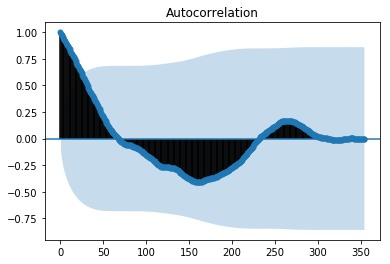

In [62]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

price = newbitcoin.iloc[:,-1].values
date = newbitcoin.iloc[:,0].values
plot_acf(price, ax=pyplot.gca())
pyplot.show()

C:\Users\ramit\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


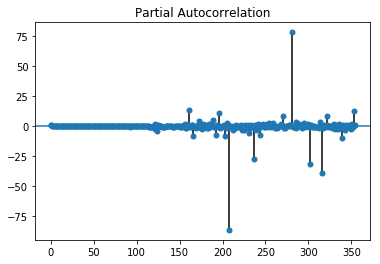

In [63]:
plot_pacf(price, ax=pyplot.gca())
pyplot.show()

In [64]:
from statsmodels.tsa.arima_model import ARIMA
xarima = ARIMA(price,order=(1,0,0)).fit()

In [65]:
#from statsmodels.tsa.arima_model import ARMAResults

x= xarima.forecast(steps=30)[0]
x



array([1256.45902584, 1256.02164681, 1255.5878336 , 1255.15755713,
       1254.73078857, 1254.30749932, 1253.88766102, 1253.47124554,
       1253.05822496, 1252.64857161, 1252.24225804, 1251.83925701,
       1251.43954153, 1251.04308481, 1250.64986027, 1250.25984158,
       1249.87300259, 1249.48931737, 1249.10876022, 1248.73130564,
       1248.35692833, 1247.9856032 , 1247.61730537, 1247.25201016,
       1246.88969309, 1246.53032988, 1246.17389645, 1245.8203689 ,
       1245.46972356, 1245.12193692])